In [692]:
'''Similar to generate_trajectories.ipynb, but uses a smarter algorithm to detect if the pen is touching the canvas'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import json

In [693]:
data_id = 'circular'
params = json.load(open(f"mocap_dataset/{data_id}/params.json"))
PEN_LENGTH = params['pen_length']

In [694]:
def read_mocap_csv(fname):
    with open(fname) as f:
        # Ignore first 6 lines (header) and only take first 23 columns
        df = pd.read_csv(f, skiprows=6, usecols=range(23))

        # Rename columns
        df.columns = [
            'frame',
            'time',
            'canvas_1_x',
            'canvas_1_y',
            'canvas_1_z',
            'canvas_2_x',
            'canvas_2_y',
            'canvas_2_z',
            'canvas_3_x',
            'canvas_3_y',
            'canvas_3_z',
            'pen_1_x',
            'pen_1_y',
            'pen_1_z',
            'pen_2_x',
            'pen_2_y',
            'pen_2_z',
            'pen_3_x',
            'pen_3_y',
            'pen_3_z',
            'pen_4_x',
            'pen_4_y',
            'pen_4_z',
        ]
        return df

df = read_mocap_csv(f"mocap_dataset/{data_id}/mocap.csv")
df.head()

,frame,time,canvas_1_x,canvas_1_y,canvas_1_z,canvas_2_x,canvas_2_y,canvas_2_z,canvas_3_x,canvas_3_y,...,pen_1_z,pen_2_x,pen_2_y,pen_2_z,pen_3_x,pen_3_y,pen_3_z,pen_4_x,pen_4_y,pen_4_z
0,0,0.000,-1547.057861,1121.339233,-502.475372,-1497.231201,1119.186768,-266.016266,-1732.549683,1098.625244,...,-68.530609,-1598.720337,1337.307983,-80.109207,-1607.990601,1377.282349,-108.123085,-1652.230347,1358.051636,-96.456039
1,1,0.004,-1546.208374,1121.317261,-503.261261,-1496.659302,1119.106812,-266.816040,-1731.798096,1098.572144,...,-69.174744,-1598.421631,1338.219727,-80.660172,-1607.895020,1378.196045,-108.678055,-1652.016602,1358.776611,-97.061874
2,2,0.008,-1545.451050,1121.307861,-504.039154,-1496.120850,1119.043335,-267.510620,-1731.140381,1098.494507,...,-69.717232,-1598.050415,1339.115234,-81.263077,-1607.676025,1379.037964,-109.127113,-1651.752563,1359.418213,-97.629387
3,3,0.013,-1544.687378,1121.314819,-504.827332,-1495.618286,1118.904053,-268.228424,-1730.387695,1098.541992,...,-70.235397,-1597.668091,1339.995483,-81.855751,-1607.462158,1379.856689,-109.692238,-1651.489014,1360.011475,-98.168304
4,4,0.017,-1543.912231,1121.290649,-505.586029,-1495.058594,1118.757446,-268.978699,-1729.659912,1098.505615,...,-70.837029,-1597.399780,1340.817017,-82.461166,-1607.268066,1380.673706,-110.269974,-1651.192017,1360.692627,-98.710854


In [695]:
idxs = []
states = []
for i in range(len(df)):
    canvas_1 = np.array([df['canvas_1_x'][i], df['canvas_1_y'][i], df['canvas_1_z'][i]])
    canvas_2 = np.array([df['canvas_2_x'][i], df['canvas_2_y'][i], df['canvas_2_z'][i]])
    canvas_3 = np.array([df['canvas_3_x'][i], df['canvas_3_y'][i], df['canvas_3_z'][i]])
    pen_1 = np.array([df['pen_1_x'][i], df['pen_1_y'][i], df['pen_1_z'][i]])
    pen_2 = np.array([df['pen_2_x'][i], df['pen_2_y'][i], df['pen_2_z'][i]])
    pen_3 = np.array([df['pen_3_x'][i], df['pen_3_y'][i], df['pen_3_z'][i]])
    pen_4 = np.array([df['pen_4_x'][i], df['pen_4_y'][i], df['pen_4_z'][i]])

    state = np.array([canvas_1, canvas_2, canvas_3, pen_1, pen_2, pen_3, pen_4]) / 1000 # scale mm to m
    if np.isnan(state).any():
        continue
    idxs.append(i)
    states.append(state)
states = np.array(states)
# states = states[6000:7000]

In [696]:
# Calculate centroid of each pen position (average of the 4 pen markers)
pen_centroids_x = np.mean(states[:,3:,0], axis=1)
pen_centroids_y = np.mean(states[:,3:,1], axis=1)
pen_centroids_z = np.mean(states[:,3:,2], axis=1)
pen_centroids = np.stack([pen_centroids_x, pen_centroids_y, pen_centroids_z], axis=1) # (N, 3)

# Estimate pen radius
distances = np.linalg.norm(states[:,3:,:] - np.expand_dims(pen_centroids, axis=1), axis=2)
pen_radius = np.percentile(distances, 25) # 25th percentile = median of the 30mm distances

In [697]:
# Calculate direction of pen by taking the cross product
us = states[:,3,:] - pen_centroids
vs = states[:,4,:] - pen_centroids
direction = np.cross(us, vs) # (N, 3)
direction = direction / np.linalg.norm(direction, axis=1)[:,np.newaxis]

# Calculate pen tip positions
pen_tips = []
for i in range(states.shape[0]):
    centroid = pen_centroids[i]

    # Out of these 2, pick the candidate that is closer to the canvas plane
    tip1 = centroid + direction[i] * PEN_LENGTH
    tip2 = centroid - direction[i] * PEN_LENGTH

    canvas_p1 = states[i,0]
    canvas_p2 = states[i,1]
    canvas_p3 = states[i,2]
    canvas_normal = np.cross(canvas_p2 - canvas_p1, canvas_p3 - canvas_p1)
    canvas_normal = canvas_normal / np.linalg.norm(canvas_normal)

    # Calculate length of projection of each tip onto the canvas plane
    tip1_dist = abs(np.dot(tip1 - canvas_p1, canvas_normal))
    tip2_dist = abs(np.dot(tip2 - canvas_p1, canvas_normal))

    if tip1_dist < tip2_dist:
        pen_tips.append(tip1)
    else:
        pen_tips.append(tip2)
pen_tips = np.array(pen_tips)

In [698]:
def get_corners(state):
    # Find corner that makes 90 deg with the other two, then use that to find the fourth
    middle_corner = None
    side_corners = None
    fourth_corner = None
    best_diff = np.inf
    for i in range(3):
        cur_corner = state[i] # (3,)
        other_corners = []
        for j in range(3):
            if i != j:
                other_corners.append(state[j])
        vec1 = other_corners[0] - cur_corner
        vec2 = other_corners[1] - cur_corner
        angle = np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))
        diff = np.abs(angle - np.pi/2)
        if diff < best_diff:
            best_diff = diff
            middle_corner = cur_corner
            side_corners = other_corners
            fourth_corner = cur_corner + vec1 + vec2
    return middle_corner, side_corners, fourth_corner

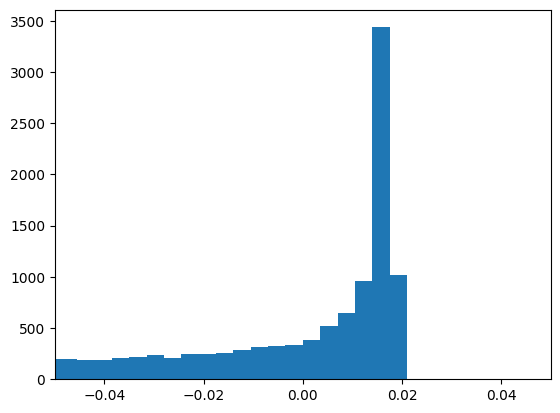

In [699]:
# Plot heights of pen tip above canvas plane as histogram
canvas_p1 = states[:,0]
canvas_p2 = states[:,1]
canvas_p3 = states[:,2]
canvas_normal = np.cross(canvas_p2 - canvas_p1, canvas_p3 - canvas_p1)
canvas_normal = canvas_normal / np.expand_dims(np.linalg.norm(canvas_normal, axis=1), 1)

heights = np.sum((pen_tips - canvas_p1) * canvas_normal, axis=1)

plt.hist(heights, bins=100)
plt.xlim([-0.05, 0.05])
plt.show()

(14000.0, 16000.0)

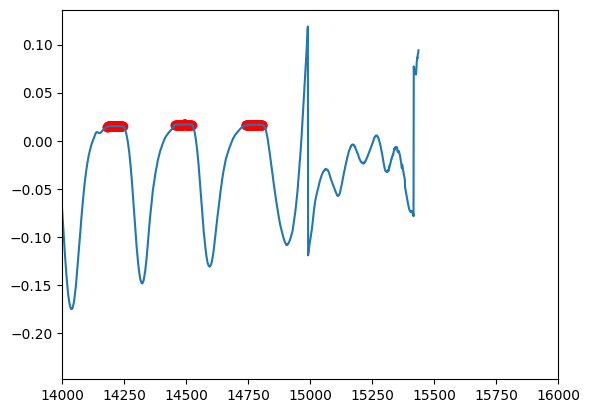

In [700]:

def get_touch_indices(heights):
    import scipy
    peaks, _ = scipy.signal.find_peaks(heights, distance=100)

    # Discard peaks that are too far from the median peak height
    median_peak_height = np.median(heights[peaks])
    threshold = 0.01
    peaks = peaks[heights[peaks] > median_peak_height - threshold]
    peaks = peaks[heights[peaks] < median_peak_height + threshold]

    # Propagate each peak left & right while the derivative is small enough
    derivs = np.diff(heights)
    derivs = np.convolve(derivs, np.ones(5)/5, mode='same') # smooth derivatives
    threshold = 0.0001
    touch_pts = set()
    for peak in peaks:
        i = peak
        while i >= 0 and abs(derivs[i]) < threshold:
            touch_pts.add(i)
            i -= 1
        i = peak
        while i < len(derivs) and abs(derivs[i]) < threshold:
            touch_pts.add(i)
            i += 1
    touch_pts = list(touch_pts)
    touch_pts = sorted(touch_pts)

    # Merge groups of points that are within 50 indices of each other
    merged_touch_pts = []
    for i in range(len(touch_pts)):
        merged_touch_pts.append(touch_pts[i])
        if i < len(touch_pts) - 1:
            cur = touch_pts[i]
            nex = touch_pts[i+1]
            if nex - cur <= 50:
                for j in range(cur+1, nex):
                    merged_touch_pts.append(j)
    touch_pts = merged_touch_pts
    
    # Delete groups of touch points whose length is less than 5
    cur_group = []
    eroded_touch_pts = []
    for pt in touch_pts:
        if len(cur_group) > 0 and pt - cur_group[-1] == 1:
            cur_group.append(pt)
        else:
            if len(cur_group) > 5:
                eroded_touch_pts.extend(cur_group)
            cur_group = [pt]
    if len(cur_group) > 5:
        eroded_touch_pts.extend(cur_group)

    touch_pts = eroded_touch_pts
    
    return touch_pts

touch_indices = get_touch_indices(heights)

# Plot heights over time
plt.plot(heights)
plt.scatter(touch_indices, heights[touch_indices], c='r')
idx = 14000
plt.xlim(idx, idx+2000)

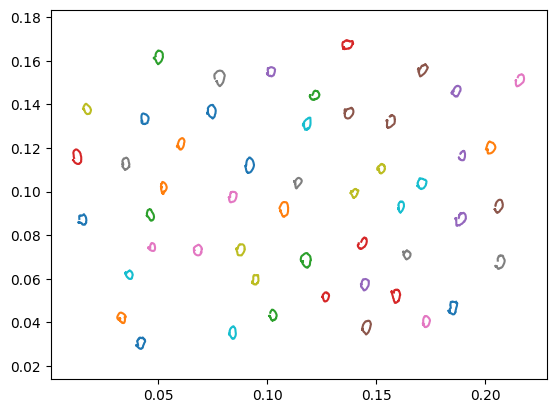

In [701]:
# For each touch index, project the pen tip onto the canvas plane
trajectories = []
cur_trajectory = []
last_touch_idx = -1
for i in touch_indices:
    tip = pen_tips[i]
    canvas_p1, canvas_p2, canvas_p3 = states[i,0], states[i,1], states[i,2]
    canvas_normal = np.cross(canvas_p2 - canvas_p1, canvas_p3 - canvas_p1)
    canvas_normal = canvas_normal / np.linalg.norm(canvas_normal)

    middle_corner, side_corners, fourth_corner = get_corners(states[i])
    u1 = side_corners[0] - middle_corner
    u2 = side_corners[1] - middle_corner

    # Calculate pen tip position in basis u1, u2
    x = np.dot(tip - middle_corner, u1) / np.linalg.norm(u1) ** 2
    y = np.dot(tip - middle_corner, u2) / np.linalg.norm(u2) ** 2
    if x < 0 or y < 0 or x > 1 or y > 1:
        continue

    canvas_pos = [x * np.linalg.norm(u1), np.linalg.norm(u2)*(1-y)]

    if last_touch_idx == i - 1:
        cur_trajectory.append(canvas_pos)
    else:
        if len(cur_trajectory) > 0:
            trajectories.append(cur_trajectory)
        cur_trajectory = [canvas_pos]

    last_touch_idx = i
if len(cur_trajectory) > 0:
    trajectories.append(cur_trajectory)

# Plot each trajectory as a polyline
plt.axis('equal')
for trajectory in trajectories:
    plt.plot([p[0] for p in trajectory], [p[1] for p in trajectory], '-')

# Save trajectories
with open(f"mocap_dataset/{data_id}/trajectories.pkl", 'wb') as f:
    pickle.dump(trajectories, f)